In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

from copy import deepcopy
import missingno as msno
import time

from StochasticGradientDescent import SGD
from ScaledConjugateGradient import SCG
from LeapFrog import LFrog
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer

from scipy.stats import shapiro
from scipy import stats
from scipy.stats import kruskal

In [17]:
breast_cancer_df = pd.read_csv('data/BreastCancer.csv')
breast_cancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### Firstly remove the unique feature

In [18]:
breast_cancer_df = breast_cancer_df.drop(['id', 'Unnamed: 32'],axis=1)
breast_cancer_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Check for Missing values

In [19]:
breast_cancer_df.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

### Perform outlier detection

In [20]:
X = breast_cancer_df.drop('diagnosis', axis=1)
y = breast_cancer_df['diagnosis']

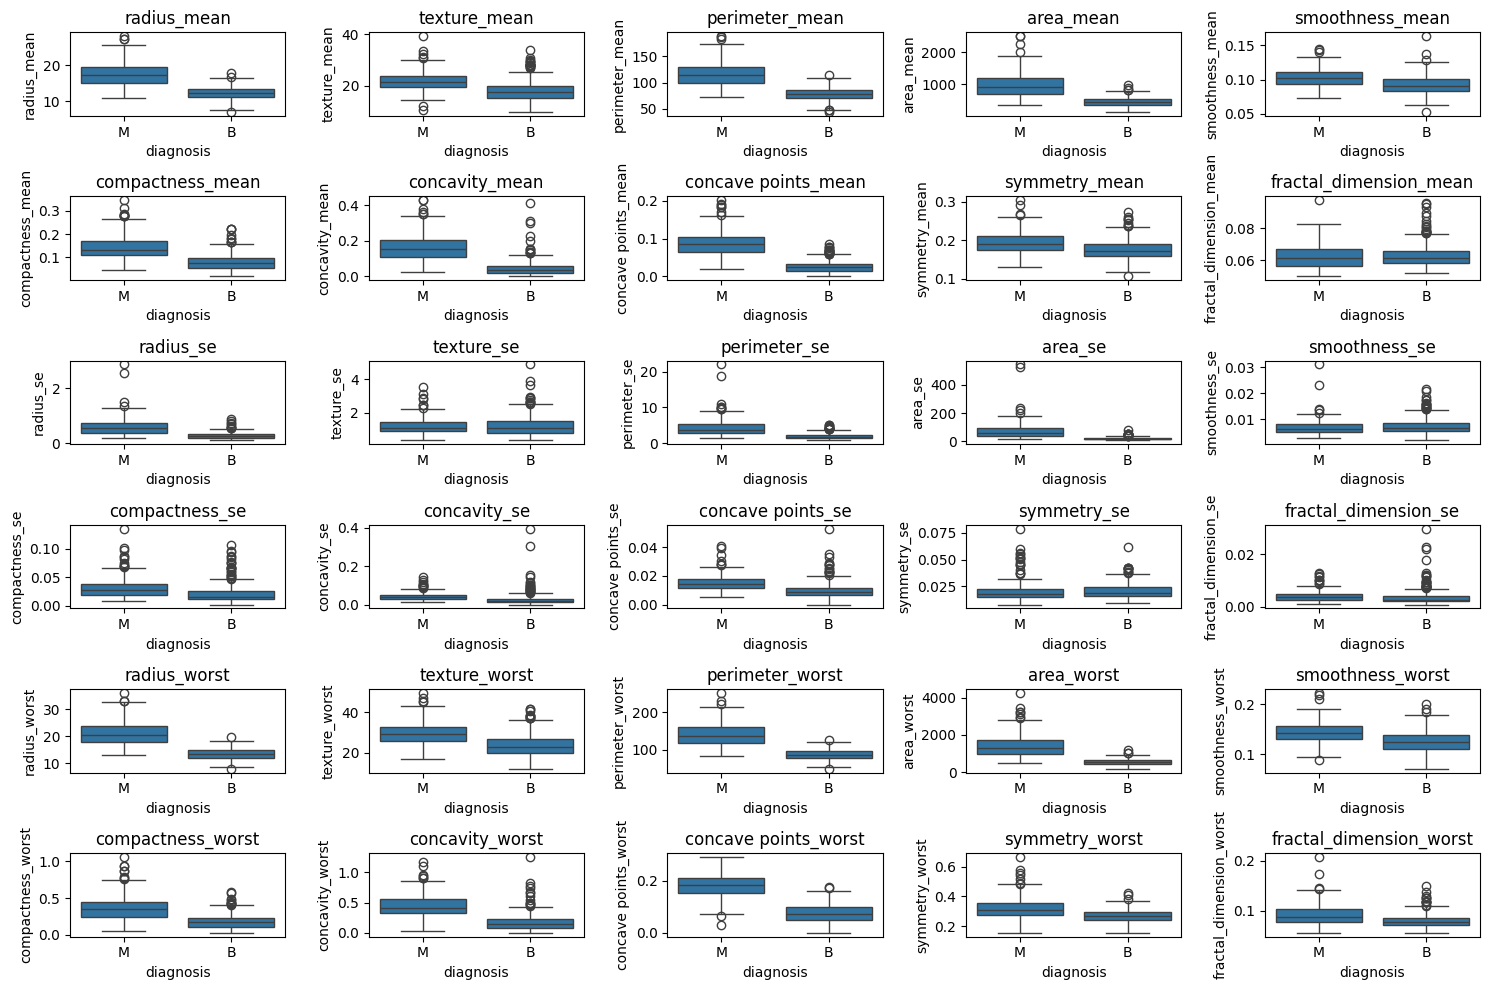

In [21]:
features = X.columns
plt.figure(figsize=(15,10))

for i, feature in enumerate(features):
    plt.subplot(6, 5, i + 1)  # 3x3 grid for subplots
    sns.boxplot(x='diagnosis', y=feature, data=breast_cancer_df)
    plt.title(feature)
    plt.tight_layout()

plt.show()

### Check for Imbalanced class data

In [22]:
y.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [23]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [24]:
y.value_counts()

diagnosis
M    357
B    357
Name: count, dtype: int64

### Scale the data

In [25]:
X_scaled = (X - X.mean()) / X.std()
X_scaled.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,...,7.140000e+02,7.140000e+02,7.140000e+02,714.000000,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02,7.140000e+02
mean,-1.393221e-16,-5.970947e-17,7.762232e-16,1.094674e-16,3.881116e-16,-4.080147e-16,-2.985474e-17,1.293705e-16,-6.169979e-16,-5.722158e-16,...,1.691768e-16,-6.369011e-16,5.970947e-17,0.000000,-5.970947e-17,4.975789e-17,1.492737e-16,2.189347e-16,-3.184505e-16,-2.040074e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.137801e+00,-2.398971e+00,-2.095540e+00,-1.564261e+00,-3.344229e+00,-1.761841e+00,-1.266338e+00,-1.411621e+00,-2.904385e+00,-1.871997e+00,...,-1.849920e+00,-2.404153e+00,-1.821764e+00,-1.340122,-2.852276e+00,-1.594250e+00,-1.470133e+00,-1.922250e+00,-2.222853e+00,-1.689863e+00
25%,-7.510303e-01,-6.848883e-01,-7.443840e-01,-7.391675e-01,-7.043367e-01,-7.736723e-01,-8.170576e-01,-8.218436e-01,-6.916447e-01,-7.096653e-01,...,-7.679749e-01,-7.236151e-01,-7.753918e-01,-0.729962,-6.485378e-01,-7.240052e-01,-7.967266e-01,-8.010802e-01,-6.423271e-01,-6.862030e-01
50%,-2.241050e-01,-3.751216e-02,-2.095842e-01,-3.149537e-01,4.804385e-03,-1.114656e-01,-2.017913e-01,-1.918890e-01,-6.685970e-02,-1.746368e-01,...,-2.255411e-01,-2.430281e-02,-2.200461e-01,-0.330536,-1.231262e-02,-2.012512e-01,-8.895397e-02,-7.371789e-02,-1.404652e-01,-2.038461e-01
75%,7.504030e-01,5.796381e-01,7.229769e-01,6.406401e-01,6.618743e-01,5.438486e-01,6.180659e-01,7.021528e-01,5.248428e-01,4.719340e-01,...,6.577380e-01,6.855287e-01,6.576536e-01,0.545176,6.480598e-01,5.756149e-01,5.793137e-01,7.865915e-01,4.120213e-01,4.375920e-01
max,3.651211e+00,4.709783e+00,3.653526e+00,4.864949e+00,4.954931e+00,4.504089e+00,4.084280e+00,3.672490e+00,4.581692e+00,5.164984e+00,...,3.771794e+00,3.910697e+00,3.971329e+00,5.533139,3.995909e+00,5.061807e+00,4.589920e+00,2.488762e+00,5.865932e+00,6.949152e+00


### Perform feature selection on the data

Explained variance by each component: [4.48712611e+01 1.87727540e+01 9.44639302e+00 6.47326406e+00
 5.22949913e+00 4.15827174e+00 2.27525234e+00 1.62149382e+00
 1.30662015e+00 1.12636649e+00 9.40337259e-01 8.49367519e-01
 7.92768507e-01 5.00307167e-01 3.12875886e-01 2.54235159e-01
 1.95563498e-01 1.70428919e-01 1.59881969e-01 1.05959545e-01
 9.95660158e-02 9.05153057e-02 8.07901204e-02 6.17922801e-02
 4.98194553e-02 2.61046425e-02 2.08635372e-02 5.00612188e-03
 2.20751821e-03 4.33759649e-04]
Sum of explained variance for the first 10 components: 95.28117581319322


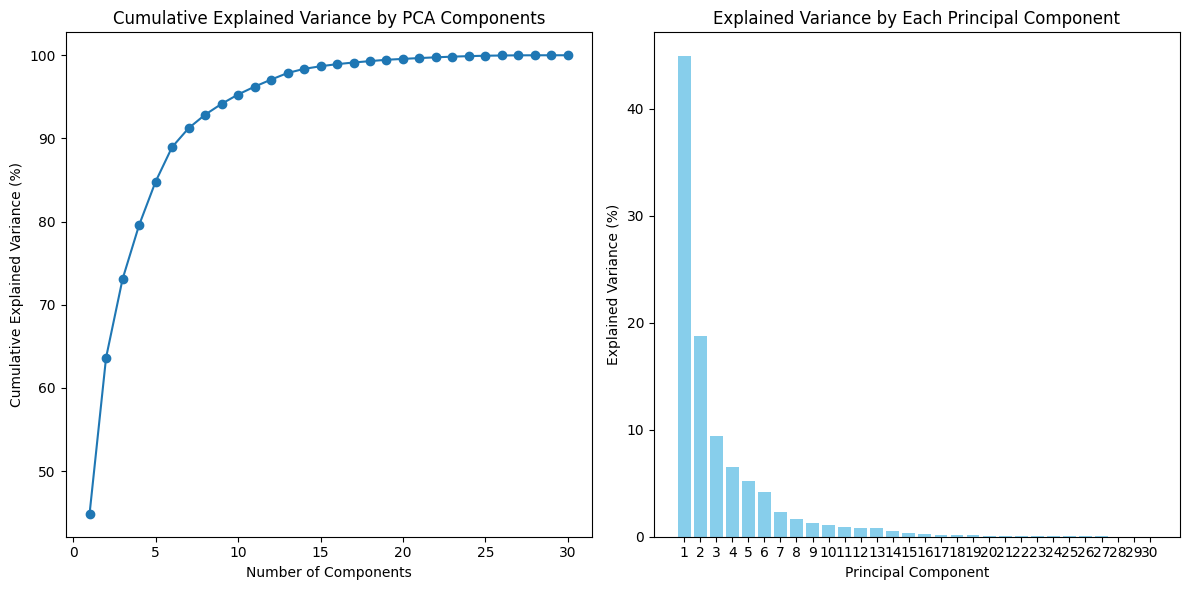

In [26]:
# Step 1: Fit PCA
pca = PCA(n_components=30)
X_pca = pca.fit_transform(X_scaled)

# Step 2: Examine explained variance
explained_variance = pca.explained_variance_ratio_ * 100
print("Explained variance by each component:", explained_variance)
print("Sum of explained variance for the first 10 components:", np.sum(explained_variance[0:10]))

# Step 3: Plot explained variance and cumulative explained variance
plt.figure(figsize=(12, 6))

# Subplot 1: Cumulative Explained Variance
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
# plt.grid()

# Subplot 2: Explained Variance by Each Principal Component
plt.subplot(1, 2, 2)
plt.bar(np.arange(1, len(explained_variance) + 1), explained_variance, color='skyblue')
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.xticks(np.arange(1, len(explained_variance) + 1))
# plt.grid()

plt.tight_layout()
plt.show()

In [27]:
# Step 2: Fit PCA
pca = PCA(n_components=10)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)

# Step 3: Examine explained variance
explained_variance = pca.explained_variance_ratio_ * 100
print("Explained variance by each component:", explained_variance)
print(np.sum(explained_variance))

Explained variance by each component: [44.8712611  18.77275396  9.44639302  6.47326406  5.22949913  4.15827174
  2.27525234  1.62149382  1.30662015  1.12636649]
95.28117581319322


## Split the data into training, validation and test sets and encode the target feature.

In [28]:
y_encoded = [0 if u == 'M' else 1 for u in y]
y_encoded = np.asarray(y_encoded)
y_encoded = y_encoded.reshape(-1,1)

In [29]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

### Fit the Stochastic Gradient Descent model to the data

In [16]:
sgd = SGD(eta=0.01, alpha=0.1, epochs=100, num_hidden=4, output_activation='sigmoid', reg_parameter=0.01, random_state=1)
sgd.fit(X_train, y_train, X_val, y_val)

In [17]:
y_pred = sgd.predict(X_test)
y_pred = [0 if u < 0.5 else 1 for u in y_pred]
(np.asarray(y_pred) == y_test.flatten()).sum() / len(y_test)

0.9629629629629629

In [18]:
y_pred = np.asarray(y_pred).reshape(-1,1)
# Generate classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        54
           1       0.93      1.00      0.96        54

    accuracy                           0.96       108
   macro avg       0.97      0.96      0.96       108
weighted avg       0.97      0.96      0.96       108



In [19]:
y_pred = sgd.predict(X_train)
y_pred = [0 if u < 0.5 else 1 for u in y_pred]
(np.asarray(y_pred) == y_train.flatten()).sum() / len(y_train)

0.9859719438877755

In [20]:
# Generate classification report
report = classification_report(y_train, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       250
           1       0.98      0.99      0.99       249

    accuracy                           0.99       499
   macro avg       0.99      0.99      0.99       499
weighted avg       0.99      0.99      0.99       499



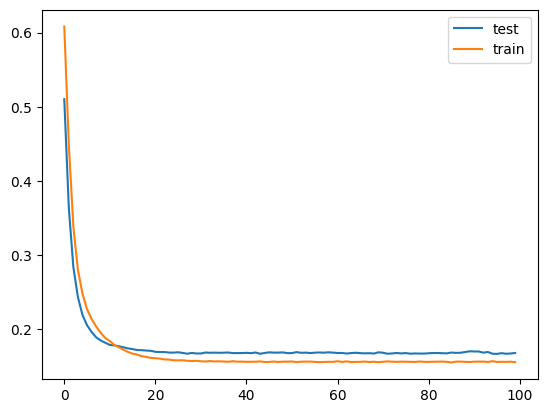

In [21]:
plt.figure()

plt.plot(np.asarray(sgd.validation_error))
plt.plot(np.asarray(sgd.training_error))

plt.legend(['test', 'train'])
plt.show()

### Fit the Scaled Conjugate Gradient model to the data

In [22]:
scg = SCG(num_hidden=4, output_activation='sigmoid', random_state=1, reg_parameter=0.01)
scg.fit(X_train, y_train, X_val, y_val)

In [23]:
y_pred = scg.predict(X_test)
y_pred = [0 if u < 0.5 else 1 for u in y_pred]
(np.asarray(y_pred) == y_test.flatten()).sum() / len(y_test)

0.9444444444444444

In [24]:
y_pred = scg.predict(X_train)
y_pred = [0 if u < 0.5 else 1 for u in y_pred]
(np.asarray(y_pred) == y_train.flatten()).sum() / len(y_train)

0.9859719438877755

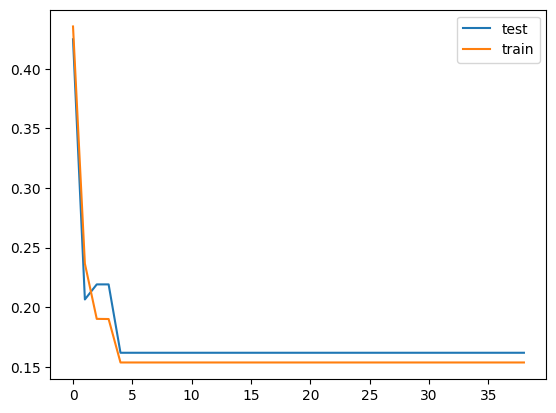

In [25]:
plt.figure()

plt.plot(np.asarray(scg.validation_error))
plt.plot(np.asarray(scg.training_error))

plt.legend(['test', 'train'])
plt.show()

### Fit the LeapFrog algorithm to the data

In [26]:
lf = LFrog(num_hidden=4, output_activation='sigmoid', random_state=1, reg_parameter=0.01)
lf.fit(X_train, y_train, X_val, y_val)

In [27]:
y_pred = lf.predict(X_test)
y_pred = [0 if u < 0.5 else 1 for u in y_pred]
(np.asarray(y_pred) == y_test.flatten()).sum() / len(y_test)

0.9537037037037037

In [28]:
y_pred = lf.predict(X_train)
y_pred = [0 if u < 0.5 else 1 for u in y_pred]
(np.asarray(y_pred) == y_train.flatten()).sum() / len(y_train)

0.9839679358717435

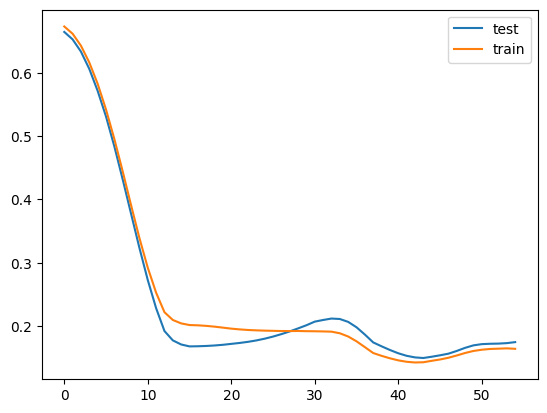

In [29]:
plt.figure()

plt.plot(np.asarray(lf.validation_error))
plt.plot(np.asarray(lf.training_error))

plt.legend(['test', 'train'])
plt.show()

# Perform hyperparameter tuning of the models

## Stochastic Gradient Descent

Testing with 1 hidden units
Average Train Error: 0.5528, Average Validation Error: 0.5532, Average Time: 1.5978
Testing with 2 hidden units
Average Train Error: 0.5488, Average Validation Error: 0.5428, Average Time: 1.0193
Testing with 3 hidden units
Average Train Error: 0.5291, Average Validation Error: 0.5258, Average Time: 1.4636
Testing with 4 hidden units
Average Train Error: 0.4757, Average Validation Error: 0.4775, Average Time: 1.4743
Testing with 5 hidden units
Average Train Error: 0.4741, Average Validation Error: 0.4741, Average Time: 1.5267
Testing with 6 hidden units
Average Train Error: 0.4800, Average Validation Error: 0.4799, Average Time: 1.2336
Testing with 7 hidden units
Average Train Error: 0.4750, Average Validation Error: 0.4751, Average Time: 1.4810
Testing with 8 hidden units
Average Train Error: 0.4802, Average Validation Error: 0.4807, Average Time: 1.0194
Testing with 9 hidden units
Average Train Error: 0.4778, Average Validation Error: 0.4791, Average Time:

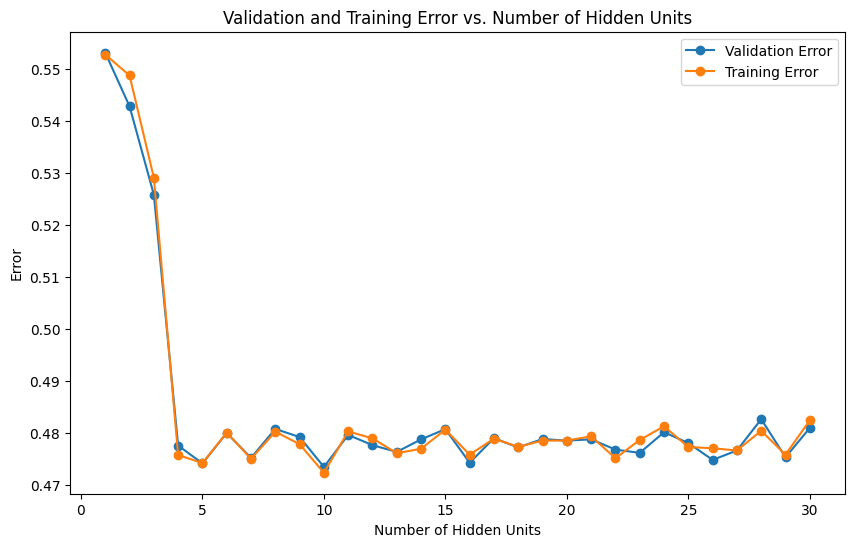

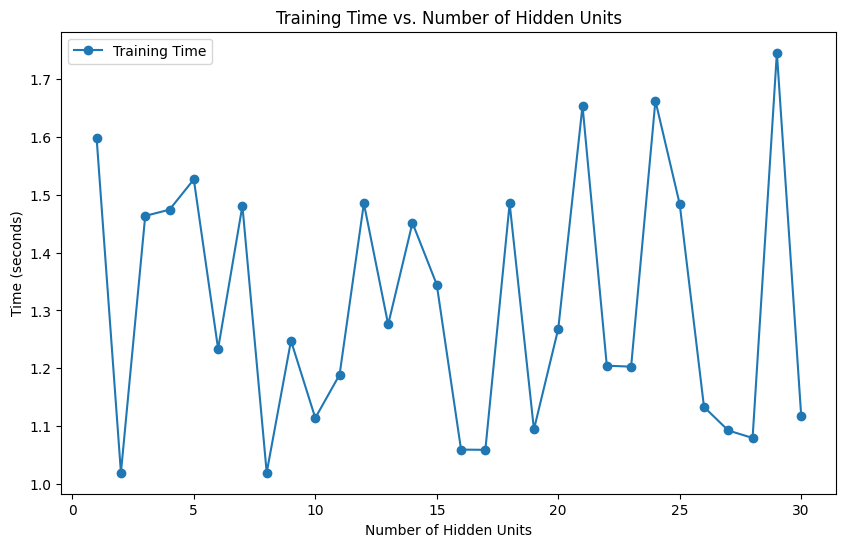

In [16]:
hidden_unit_options = [i for i in range(1, 31)]  # Range of hidden units to test
kf = KFold(n_splits=5, shuffle=True, random_state=42)

sgd_val_errors = []
sgd_train_errors = []
sgd_train_times = []
sgd_all_val_errors = []
sgd_all_training_errors = []

for num_hidden in hidden_unit_options:
    print(f"Testing with {num_hidden} hidden units")
    val_errors_fold = []
    train_errors_fold = []
    fold_times = []
    count = 0
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X_pca[train_index], X_pca[val_index]
        y_train, y_val = y_encoded[train_index], y_encoded[val_index]
        count += 1
        
        # Initialize the model with current number of hidden units
        model = SGD(eta=0.1, alpha=0.8, epochs=100, num_hidden=num_hidden, reg_parameter=0.1, output_activation='sigmoid', random_state=count)
        
        # Train the model and measure the time taken
        start_time = time.time()
        model.fit(X_train, y_train, X_val, y_val)
        end_time = time.time()
        
        # Calculate training and validation errors
        train_error = model.calculate_error(X_train, y_train)
        val_error = model.calculate_error(X_val, y_val)
        
        train_errors_fold.append(train_error)
        val_errors_fold.append(val_error)
        fold_times.append(end_time - start_time)
    
    # Store the average results for this number of hidden units
    sgd_train_errors.append(np.mean(train_errors_fold))
    sgd_val_errors.append(np.mean(val_errors_fold))
    sgd_train_times.append(np.mean(fold_times))
    sgd_all_val_errors.append(val_errors_fold)
    sgd_all_training_errors.append(train_errors_fold)
    
    print(f"Average Train Error: {sgd_train_errors[-1]:.4f}, Average Validation Error: {sgd_val_errors[-1]:.4f}, Average Time: {sgd_train_times[-1]:.4f}")


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_options, sgd_val_errors, label='Validation Error', marker='o')
plt.plot(hidden_unit_options, sgd_train_errors, label='Training Error', marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Error')
plt.title('Validation and Training Error vs. Number of Hidden Units')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_options, sgd_train_times, label='Training Time', marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Time (seconds)')
plt.title('Training Time vs. Number of Hidden Units')
plt.legend()
plt.show()

In [17]:
stat, p_value = shapiro(sgd_all_val_errors)

print(f'Statistic={stat}, p-value={p_value}')
if p_value > 0.05:
    print("Data is normally distributed")
else:
    print("Data is not normally distributed")

Statistic=0.641929460733511, p-value=1.3922977096957966e-17
Data is not normally distributed


In [20]:
stat, p_value = kruskal(*sgd_all_val_errors)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 27.300210526315794, p-value: 0.017593820018196284


In [21]:
# Perform statistical tests
for i in range(len(hidden_unit_options) - 1):
    n1, n2 = hidden_unit_options[i], hidden_unit_options[i+1]
    errors1, errors2 = sgd_all_val_errors[i], sgd_all_val_errors[i+1]
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(errors1, errors2)
    
    # Effect size (Cohen's d)
    mean_diff = np.mean(errors1) - np.mean(errors2)
    pooled_std = np.sqrt((np.std(errors1, ddof=1)**2 + np.std(errors2, ddof=1)**2) / 2)
    effect_size = mean_diff / pooled_std
    
    print(f"\nComparing {n1} vs {n2} hidden units:")
    print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"Effect size (Cohen's d): {effect_size:.4f}")

# Calculate 95% confidence intervals and mean errors
print("\n95% Confidence Intervals and Mean Errors:")
for i, num_hidden in enumerate(hidden_unit_options):
    errors = sgd_all_val_errors[i]
    mean_error = np.mean(errors)
    ci = stats.t.interval(0.95, len(errors)-1, loc=mean_error, scale=stats.sem(errors))
    print(f"{num_hidden} hidden units: Mean Error = {mean_error:.4f}, 95% CI: {ci}")

# One-way ANOVA
f_statistic, p_value = stats.f_oneway(*sgd_all_val_errors)
print(f"\nOne-way ANOVA: F-statistic = {f_statistic:.4f}, p-value = {p_value:.4f}")


Comparing 1 vs 2 hidden units:
Paired t-test: t-statistic = 0.6184, p-value = 0.5698
Effect size (Cohen's d): 0.3293

Comparing 2 vs 3 hidden units:
Paired t-test: t-statistic = 0.5058, p-value = 0.6396
Effect size (Cohen's d): 0.3908

Comparing 3 vs 4 hidden units:
Paired t-test: t-statistic = 2.2685, p-value = 0.0859
Effect size (Cohen's d): 1.4667

Comparing 4 vs 5 hidden units:
Paired t-test: t-statistic = 0.9593, p-value = 0.3917
Effect size (Cohen's d): 0.3080

Comparing 5 vs 6 hidden units:
Paired t-test: t-statistic = -2.4753, p-value = 0.0686
Effect size (Cohen's d): -0.4727

Comparing 6 vs 7 hidden units:
Paired t-test: t-statistic = 1.8803, p-value = 0.1332
Effect size (Cohen's d): 0.5029

Comparing 7 vs 8 hidden units:
Paired t-test: t-statistic = -2.7816, p-value = 0.0497
Effect size (Cohen's d): -0.9170

Comparing 8 vs 9 hidden units:
Paired t-test: t-statistic = 0.6734, p-value = 0.5376
Effect size (Cohen's d): 0.2392

Comparing 9 vs 10 hidden units:
Paired t-test: t-st

In [38]:
def cross_validate(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    folds = []

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        folds.append(list(val_index))

    for n, fold in enumerate(folds):
        X_test, y_test = X[folds[n-1]], y[folds[n-1]]
        X_val, y_val = X[folds[n-2]], y[folds[n-2]]

        train_folds = folds.copy()
        train_folds.remove(folds[n-1])
        train_folds.remove(folds[n-2])

        # Flatten train_folds to get a single list of training indices
        train_indices = np.concatenate(train_folds)

        X_train = X[train_indices].reshape(-1, 10)
        y_train = y[train_indices].reshape(-1,1)

        model.random_state = n
        model.validation_error = []
        model.training_error = []
        model.fit(X_train, y_train, X_val, y_val)
        score = model.score(X_test, y_test)
        scores.append(1 - score)
    
    return np.mean(scores)

# Define the objective function to minimize (validation error)
def objective(params):
    eta, alpha, reg_parameter, num_epochs, num_hidden, bias_parameter = params
    print(params)

    # Initialize the model with the current set of hyperparameters
    model = SGD(eta=eta, alpha=alpha, epochs=num_epochs, num_hidden=num_hidden, reg_parameter=reg_parameter, output_activation='sigmoid', bias=bias_parameter)

    # Perform cross-validation
    cv_score = cross_validate(model, X_pca, y_encoded)
    
    return cv_score  # Return mean cross-validation error

# Define the hyperparameter search space
search_space = [
    Real(1e-3, 1e-1, "log-uniform", name='eta'),
    Real(0, 0.99, "uniform", name='alpha'),
    Real(1e-4, 1, "uniform", name='reg_parameter'),
    Integer(10, 100, name='num_epochs'),
    Integer(4, 15, name='num_hidden'),
    Real(-1, 1, name='bias_parameter')
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    n_initial_points=20,
    random_state=0,
    n_jobs = 1,
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Learning rate (eta): {result.x[0]}")
print(f"Momentum (alpha): {result.x[1]}")
print(f"Regularization (lambda): {result.x[2]}")
print(f"Number of epochs units: {result.x[3]}")
print(f"Number of hidden units: {result.x[4]}")
print(f"Bias value: {result.x[5]}")

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 0.8358230910952074, 0.8579598230609947, 86, 11, -0.23123658541460013]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 8.1973
Function value obtained: 0.5014
Current minimum: 0.5014
Iteration No: 2 started. Evaluating function at random point.
[0.003936128001463711, 0.05614584754426876, 0.27272902895065526, 53, 13, -0.040045655249885126]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.9883
Function value obtained: 0.0840
Current minimum: 0.0840
Iteration No: 3 started. Evaluating function at random point.
[0.006103368503860312, 0.827717975902004, 0.3374624208012267, 68, 8, 0.9143103179060932]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.6762
Function value obtained: 0.2855
Current minimum: 0.0840
Iteration No: 4 started. Evaluating function at random point.
[0.0019085412933888726, 0.8613863857748523, 0.4736606844691832, 82, 10, 0.35775

In [39]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.4, random_state=0, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, shuffle=True)

In [40]:
best_sgd_model = SGD(eta=result.x[0], alpha=result.x[1], reg_parameter=result.x[2], num_hidden=result.x[4], output_activation='sigmoid', epochs=result.x[3], random_state=0, bias=result.x[5])
best_sgd_model.fit(X_train, y_train, X_val, y_val)

In [41]:
best_sgd_model.score(X_test, y_test)

0.958041958041958

In [42]:
best_sgd_model.score(X_train, y_train)

0.9836448598130841

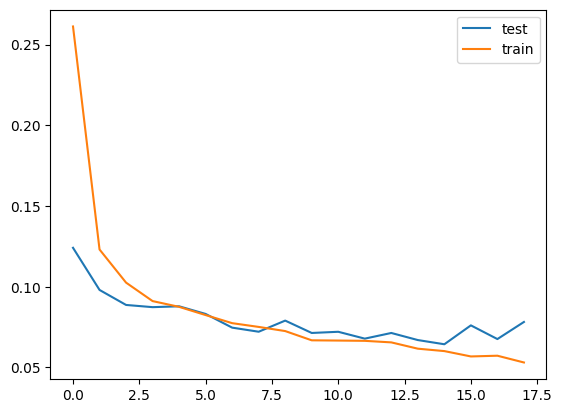

In [43]:
plt.figure()

plt.plot(np.asarray(best_sgd_model.validation_error))
plt.plot(np.asarray(best_sgd_model.training_error))

plt.legend(['test', 'train'])
plt.show()

## Scaled Conjugate Gradient

Testing with 1 hidden units
Average Train Error: 0.5765, Average Validation Error: 0.5746, Average Time: 0.0236
Testing with 2 hidden units
Average Train Error: 0.5606, Average Validation Error: 0.5543, Average Time: 0.0282
Testing with 3 hidden units
Average Train Error: 0.5378, Average Validation Error: 0.5347, Average Time: 0.0231
Testing with 4 hidden units
Average Train Error: 0.4556, Average Validation Error: 0.4551, Average Time: 0.0269
Testing with 5 hidden units
Average Train Error: 0.4686, Average Validation Error: 0.4702, Average Time: 0.0264
Testing with 6 hidden units
Average Train Error: 0.4888, Average Validation Error: 0.4893, Average Time: 0.0303
Testing with 7 hidden units
Average Train Error: 0.5000, Average Validation Error: 0.5015, Average Time: 0.0322
Testing with 8 hidden units
Average Train Error: 0.4776, Average Validation Error: 0.4796, Average Time: 0.0304
Testing with 9 hidden units
Average Train Error: 0.4853, Average Validation Error: 0.4869, Average Time:

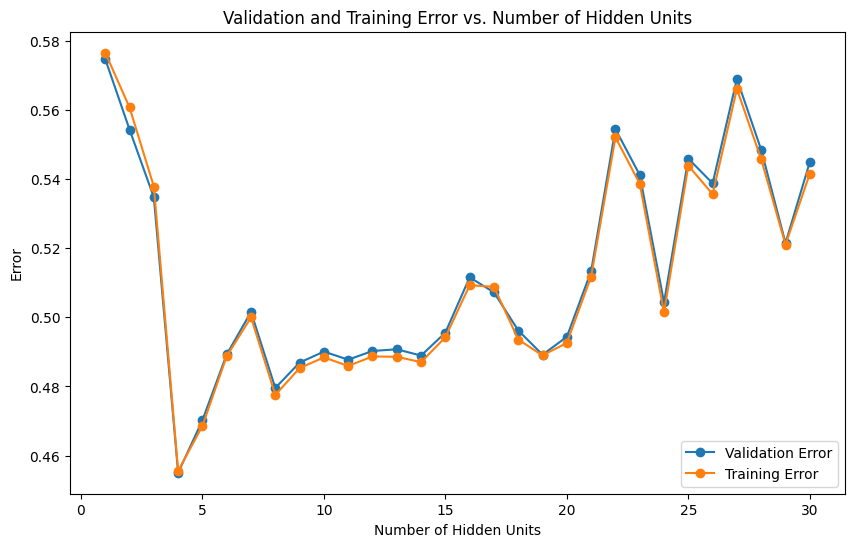

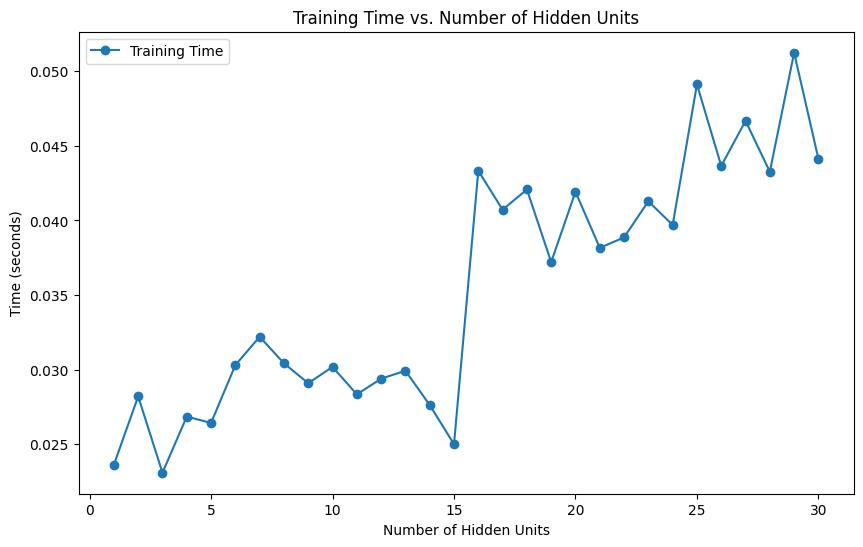

In [28]:
hidden_unit_options = [i for i in range(1, 31)]  # Range of hidden units to test
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scg_val_errors = []
scg_train_errors = []
scg_train_times = []
scg_all_val_errors = []
scg_all_training_errors = []

for num_hidden in hidden_unit_options:
    print(f"Testing with {num_hidden} hidden units")
    val_errors_fold = []
    train_errors_fold = []
    fold_times = []
    count = 0
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X_pca[train_index], X_pca[val_index]
        y_train, y_val = y_encoded[train_index], y_encoded[val_index]
        count += 1
        
        # Initialize the model with current number of hidden units
        model = SCG(num_hidden=num_hidden, reg_parameter=0.1, output_activation='sigmoid', random_state=count, debug=False, num_batches=1)
        
        # Train the model and measure the time taken
        start_time = time.time()
        model.fit(X_train, y_train, X_val, y_val)
        end_time = time.time()
        
        # Calculate training and validation errors
        train_error = model.calculate_error_for_weights(model.weights, X_train, y_train)
        val_error = model.calculate_error_for_weights(model.weights, X_val, y_val)
        train_errors_fold.append(train_error)
        val_errors_fold.append(val_error)
        fold_times.append(end_time - start_time)
    
    # Store the average results for this number of hidden units
    scg_train_errors.append(np.mean(train_errors_fold))
    scg_val_errors.append(np.mean(val_errors_fold))
    scg_train_times.append(np.mean(fold_times))
    scg_all_val_errors.append(val_errors_fold)
    scg_all_training_errors.append(train_errors_fold)
    
    print(f"Average Train Error: {scg_train_errors[-1]:.4f}, Average Validation Error: {scg_val_errors[-1]:.4f}, Average Time: {scg_train_times[-1]:.4f}")


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_options, scg_val_errors, label='Validation Error', marker='o')
plt.plot(hidden_unit_options, scg_train_errors, label='Training Error', marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Error')
plt.title('Validation and Training Error vs. Number of Hidden Units')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_options, scg_train_times, label='Training Time', marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Time (seconds)')
plt.title('Training Time vs. Number of Hidden Units')
plt.legend()
plt.show()

In [29]:
stat, p_value = shapiro(scg_all_val_errors)

print(f'Statistic={stat}, p-value={p_value}')
if p_value > 0.05:
    print("Data is normally distributed")
else:
    print("Data is not normally distributed")

Statistic=0.8998118257012907, p-value=1.2901714381322141e-08
Data is not normally distributed


In [30]:
stat, p_value = kruskal(*scg_all_val_errors)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 57.481059602649, p-value: 0.0012574265732504602


In [31]:
# Perform statistical tests
for i in range(len(hidden_unit_options) - 1):
    n1, n2 = hidden_unit_options[i], hidden_unit_options[i+1]
    errors1, errors2 = scg_all_val_errors[i], scg_all_val_errors[i+1]
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(errors1, errors2)
    
    # Effect size (Cohen's d)
    mean_diff = np.mean(errors1) - np.mean(errors2)
    pooled_std = np.sqrt((np.std(errors1, ddof=1)**2 + np.std(errors2, ddof=1)**2) / 2)
    effect_size = mean_diff / pooled_std
    
    print(f"\nComparing {n1} vs {n2} hidden units:")
    print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"Effect size (Cohen's d): {effect_size:.4f}")

# Calculate 95% confidence intervals and mean errors
print("\n95% Confidence Intervals and Mean Errors:")
for i, num_hidden in enumerate(hidden_unit_options):
    errors = scg_all_val_errors[i]
    mean_error = np.mean(errors)
    ci = stats.t.interval(0.95, len(errors)-1, loc=mean_error, scale=stats.sem(errors))
    print(f"{num_hidden} hidden units: Mean Error = {mean_error:.4f}, 95% CI: {ci}")

# One-way ANOVA
f_statistic, p_value = stats.f_oneway(*scg_all_val_errors)
print(f"\nOne-way ANOVA: F-statistic = {f_statistic:.4f}, p-value = {p_value:.4f}")


Comparing 1 vs 2 hidden units:
Paired t-test: t-statistic = 1.7282, p-value = 0.1590
Effect size (Cohen's d): 0.7310

Comparing 2 vs 3 hidden units:
Paired t-test: t-statistic = 0.8918, p-value = 0.4229
Effect size (Cohen's d): 0.4936

Comparing 3 vs 4 hidden units:
Paired t-test: t-statistic = 1.8523, p-value = 0.1376
Effect size (Cohen's d): 1.4784

Comparing 4 vs 5 hidden units:
Paired t-test: t-statistic = -0.4435, p-value = 0.6803
Effect size (Cohen's d): -0.3198

Comparing 5 vs 6 hidden units:
Paired t-test: t-statistic = -0.6382, p-value = 0.5581
Effect size (Cohen's d): -0.5572

Comparing 6 vs 7 hidden units:
Paired t-test: t-statistic = -0.4806, p-value = 0.6559
Effect size (Cohen's d): -0.3281

Comparing 7 vs 8 hidden units:
Paired t-test: t-statistic = 1.3137, p-value = 0.2592
Effect size (Cohen's d): 0.6628

Comparing 8 vs 9 hidden units:
Paired t-test: t-statistic = -0.6124, p-value = 0.5734
Effect size (Cohen's d): -0.3384

Comparing 9 vs 10 hidden units:
Paired t-test: 

In [44]:
def cross_validate(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    folds = []

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        folds.append(list(val_index))

    for n, fold in enumerate(folds):
        X_test, y_test = X[folds[n-1]], y[folds[n-1]]
        X_val, y_val = X[folds[n-2]], y[folds[n-2]]

        train_folds = folds.copy()
        train_folds.remove(folds[n-1])
        train_folds.remove(folds[n-2])

        # Flatten train_folds to get a single list of training indices
        train_indices = np.concatenate(train_folds)

        X_train = X[train_indices].reshape(-1, 10)
        y_train = y[train_indices].reshape(-1,1)

        model.random_state = n
        model.validation_error = []
        model.training_error = []
        model.lambda_bar = 0
        model.lambda_parameter = 1e-6
        model.fit(X_train, y_train, X_val, y_val)
        score = model.score(X_test, y_test)
        scores.append(1 - score)

    return np.mean(scores)

# Define the objective function to minimize (validation error)
def objective(params):
    reg_parameter, num_epochs, num_hidden, bias_parameter = params
    print(params)

    # Initialize the model with the current set of hyperparameters
    model = SCG(epochs=num_epochs, num_hidden=num_hidden, reg_parameter=reg_parameter, output_activation='sigmoid', bias=bias_parameter)

    # Perform cross-validation
    # cv_score = cross_validate(model, X_train_val, y_train_val)
    cv_score = cross_validate(model, X_pca, y_encoded)
    
    return cv_score  # Return mean cross-validation error

# Define the hyperparameter search space
search_space = [
    Real(1e-4, 1, "uniform", name='reg_parameter'),
    Integer(1000, 10000, name='num_epochs'),
    Integer(4, 15, name='num_hidden'),
    Real(-1, 1, name='bias_parameter')
]

# Run Bayesian optimization
result = gp_minimize(
    objective,                # Objective function
    search_space,             # Hyperparameter search space
    n_calls=100,               # Number of iterations
    n_initial_points=20,
    random_state=0,           # For reproducibility
    n_jobs = -1,
    verbose=True
    # acq_func="EI",
    # acq_optimizer="sampling"
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Regularization (lambda): {result.x[0]}")
print(f"Number of epochs units: {result.x[1]}")
print(f"Number of hidden units: {result.x[2]}")
print(f"Bias value: {result.x[3]}")

Iteration No: 1 started. Evaluating function at random point.
[0.592885333763196, 8598, 13, 0.6945034775682513]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2772
Function value obtained: 0.2421
Current minimum: 0.2421
Iteration No: 2 started. Evaluating function at random point.
[0.6236013404162939, 4459, 7, -0.8865740453651136]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2661
Function value obtained: 0.3643
Current minimum: 0.2421
Iteration No: 3 started. Evaluating function at random point.
[0.27272902895065526, 5299, 13, -0.040045655249885126]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2847
Function value obtained: 0.0840
Current minimum: 0.0840
Iteration No: 4 started. Evaluating function at random point.
[0.3928455176212197, 8525, 8, 0.2963437441023946]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3125
Function value obtained: 0.1330
Current minimum: 0.0840
Iteration No: 5 starte

In [45]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.3, random_state=0, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, shuffle=True)

In [46]:
best_scg_model = SCG(epochs=result.x[1], num_hidden=result.x[2], reg_parameter=result.x[0], output_activation='sigmoid', random_state=0, bias=result.x[3])
best_scg_model.fit(X_train, y_train, X_val, y_val)

In [47]:
best_scg_model.score(X_test, y_test)

0.9719626168224299

In [48]:
best_scg_model.score(X_train, y_train)

0.9919839679358717

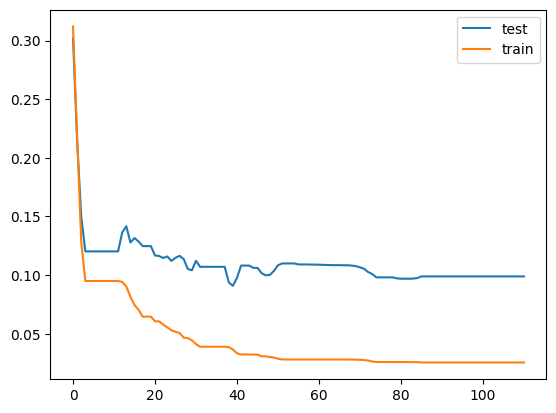

In [49]:
plt.figure()

plt.plot(np.asarray(best_scg_model.validation_error))
plt.plot(np.asarray(best_scg_model.training_error))

plt.legend(['test', 'train'])
plt.show()

# Leap Frog

Testing with 1 hidden units
Average Train Error: 0.5574, Average Validation Error: 0.5592, Average Time: 0.0377
Testing with 2 hidden units
Average Train Error: 0.5474, Average Validation Error: 0.5442, Average Time: 0.0408
Testing with 3 hidden units
Average Train Error: 0.5078, Average Validation Error: 0.5092, Average Time: 0.0377
Testing with 4 hidden units
Average Train Error: 0.4627, Average Validation Error: 0.4631, Average Time: 0.0602
Testing with 5 hidden units
Average Train Error: 0.4715, Average Validation Error: 0.4711, Average Time: 0.0418
Testing with 6 hidden units
Average Train Error: 0.4739, Average Validation Error: 0.4731, Average Time: 0.0408
Testing with 7 hidden units
Average Train Error: 0.4692, Average Validation Error: 0.4692, Average Time: 0.0391
Testing with 8 hidden units
Average Train Error: 0.4674, Average Validation Error: 0.4695, Average Time: 0.0385
Testing with 9 hidden units
Average Train Error: 0.4657, Average Validation Error: 0.4684, Average Time:

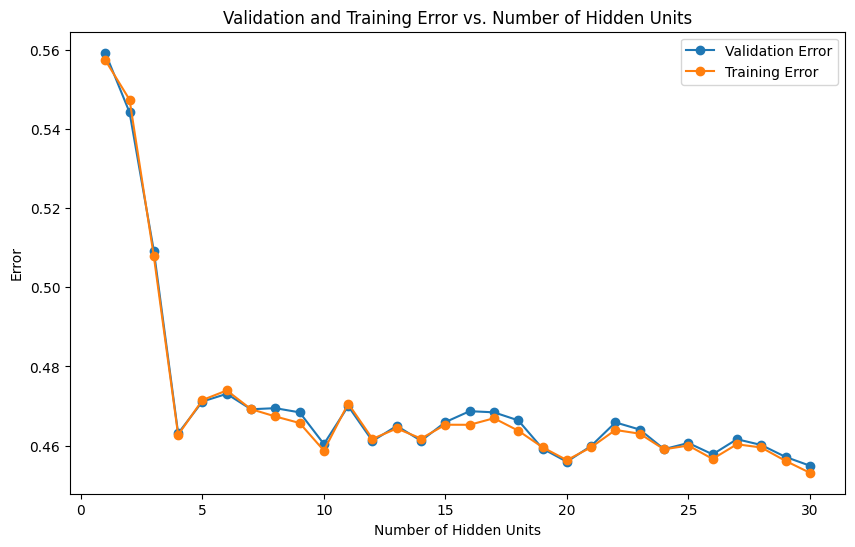

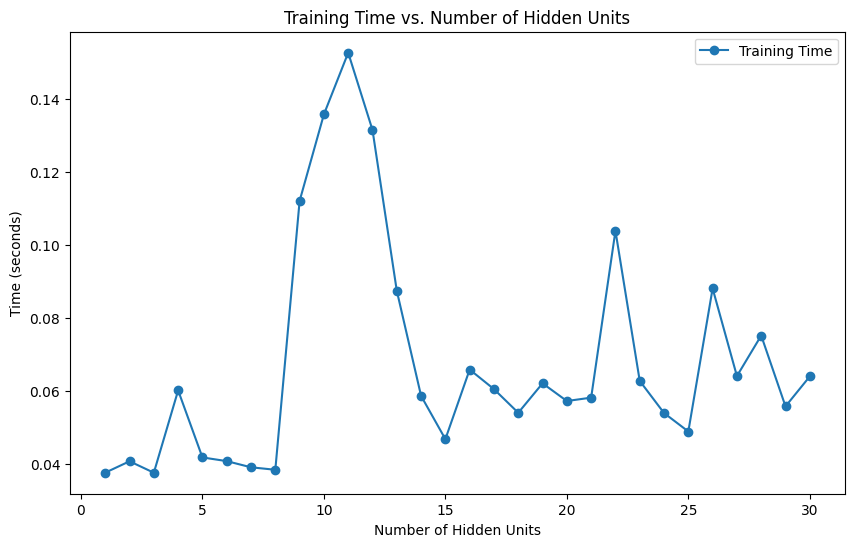

In [38]:
hidden_unit_options = [i for i in range(1, 31)]  # Range of hidden units to test
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lf_val_errors = []
lf_train_errors = []
lf_train_times = []
lf_all_val_errors = []
lf_all_training_errors = []

for num_hidden in hidden_unit_options:
    print(f"Testing with {num_hidden} hidden units")
    val_errors_fold = []
    train_errors_fold = []
    fold_times = []
    count = 0
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X_pca[train_index], X_pca[val_index]
        y_train, y_val = y_encoded[train_index], y_encoded[val_index]
        count += 1
        
        # Initialize the model with current number of hidden units
        model = LFrog(num_hidden=num_hidden, reg_parameter=0.1, output_activation='sigmoid', random_state=count, debug=False, num_batches=1)
        
        # Train the model and measure the time taken
        start_time = time.time()
        model.fit(X_train, y_train, X_val, y_val)
        end_time = time.time()
        
        # Calculate training and validation errors
        train_error = model.calculate_error_for_weights(model.weights, X_train, y_train)
        val_error = model.calculate_error_for_weights(model.weights, X_val, y_val)
        train_errors_fold.append(train_error)
        val_errors_fold.append(val_error)
        fold_times.append(end_time - start_time)
    
    # Store the average results for this number of hidden units
    lf_train_errors.append(np.mean(train_errors_fold))
    lf_val_errors.append(np.mean(val_errors_fold))
    lf_train_times.append(np.mean(fold_times))
    lf_all_val_errors.append(val_errors_fold)
    lf_all_training_errors.append(train_errors_fold)
    
    print(f"Average Train Error: {lf_train_errors[-1]:.4f}, Average Validation Error: {lf_val_errors[-1]:.4f}, Average Time: {lf_train_times[-1]:.4f}")


# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_options, lf_val_errors, label='Validation Error', marker='o')
plt.plot(hidden_unit_options, lf_train_errors, label='Training Error', marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Error')
plt.title('Validation and Training Error vs. Number of Hidden Units')
plt.legend()
plt.show()

# Plot training times
plt.figure(figsize=(10, 6))
plt.plot(hidden_unit_options, lf_train_times, label='Training Time', marker='o')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Time (seconds)')
plt.title('Training Time vs. Number of Hidden Units')
plt.legend()
plt.show()

In [39]:
stat, p_value = shapiro(lf_all_val_errors)

print(f'Statistic={stat}, p-value={p_value}')
if p_value > 0.05:
    print("Data is normally distributed")
else:
    print("Data is not normally distributed")

Statistic=0.6850916482352294, p-value=1.6196953503828459e-16
Data is not normally distributed


In [40]:
stat, p_value = kruskal(*lf_all_val_errors)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 45.155761589403994, p-value: 0.028414678680261596


In [41]:
# Perform statistical tests
for i in range(len(hidden_unit_options) - 1):
    n1, n2 = hidden_unit_options[i], hidden_unit_options[i+1]
    errors1, errors2 = lf_all_val_errors[i], lf_all_val_errors[i+1]
    
    # Paired t-test
    t_stat, p_value = stats.ttest_rel(errors1, errors2)
    
    # Effect size (Cohen's d)
    mean_diff = np.mean(errors1) - np.mean(errors2)
    pooled_std = np.sqrt((np.std(errors1, ddof=1)**2 + np.std(errors2, ddof=1)**2) / 2)
    effect_size = mean_diff / pooled_std
    
    print(f"\nComparing {n1} vs {n2} hidden units:")
    print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print(f"Effect size (Cohen's d): {effect_size:.4f}")

# Calculate 95% confidence intervals and mean errors
print("\n95% Confidence Intervals and Mean Errors:")
for i, num_hidden in enumerate(hidden_unit_options):
    errors = lf_all_val_errors[i]
    mean_error = np.mean(errors)
    ci = stats.t.interval(0.95, len(errors)-1, loc=mean_error, scale=stats.sem(errors))
    print(f"{num_hidden} hidden units: Mean Error = {mean_error:.4f}, 95% CI: {ci}")

# One-way ANOVA
f_statistic, p_value = stats.f_oneway(*lf_all_val_errors)
print(f"\nOne-way ANOVA: F-statistic = {f_statistic:.4f}, p-value = {p_value:.4f}")


Comparing 1 vs 2 hidden units:
Paired t-test: t-statistic = 0.6116, p-value = 0.5738
Effect size (Cohen's d): 0.3720

Comparing 2 vs 3 hidden units:
Paired t-test: t-statistic = 0.8404, p-value = 0.4480
Effect size (Cohen's d): 0.6618

Comparing 3 vs 4 hidden units:
Paired t-test: t-statistic = 2.1794, p-value = 0.0948
Effect size (Cohen's d): 1.2010

Comparing 4 vs 5 hidden units:
Paired t-test: t-statistic = -0.8888, p-value = 0.4243
Effect size (Cohen's d): -0.4554

Comparing 5 vs 6 hidden units:
Paired t-test: t-statistic = -0.4084, p-value = 0.7039
Effect size (Cohen's d): -0.1275

Comparing 6 vs 7 hidden units:
Paired t-test: t-statistic = 0.7714, p-value = 0.4835
Effect size (Cohen's d): 0.3533

Comparing 7 vs 8 hidden units:
Paired t-test: t-statistic = -0.0527, p-value = 0.9605
Effect size (Cohen's d): -0.0227

Comparing 8 vs 9 hidden units:
Paired t-test: t-statistic = 0.1399, p-value = 0.8955
Effect size (Cohen's d): 0.0962

Comparing 9 vs 10 hidden units:
Paired t-test: t-

In [50]:
def cross_validate(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    folds = []

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        folds.append(list(val_index))

    for n, fold in enumerate(folds):
        X_test, y_test = X[folds[n-1]], y[folds[n-1]]
        X_val, y_val = X[folds[n-2]], y[folds[n-2]]

        train_folds = folds.copy()
        train_folds.remove(folds[n-1])
        train_folds.remove(folds[n-2])

        # Flatten train_folds to get a single list of training indices
        train_indices = np.concatenate(train_folds)

        X_train = X[train_indices].reshape(-1, 10)
        y_train = y[train_indices].reshape(-1,1)

        model.random_state = n
        model.validation_error = []
        model.training_error = []
        model.fit(X_train, y_train, X_val, y_val)
        score = model.score(X_test, y_test)
        scores.append(1 - score)
    
    return np.mean(scores)

# Define the objective function to minimize (validation error)
def objective(params):
    reg_parameter, num_batches, num_epochs, num_hidden, bias_parameter = params
    print(params)

    # Initialize the model with the current set of hyperparameters
    model = LFrog(epochs=num_epochs, num_hidden=num_hidden, reg_parameter=reg_parameter, output_activation='sigmoid', num_batches=num_batches, bias=bias_parameter)

    # Perform cross-validation
    cv_score = cross_validate(model, X_pca, y_encoded)
    
    return cv_score  # Return mean cross-validation error

# Define the hyperparameter search space
search_space = [
    Real(1e-4, 1, "uniform", name='reg_parameter'),
    Integer(1, 32, name='num_batches'),
    Integer(100, 10000, name='num_epochs'),
    Integer(4, 15, name='num_hidden'),
    Real(-1, 1, name='bias_parameter')
]

# Run Bayesian optimization
result = gp_minimize(
    objective,                # Objective function
    search_space,             # Hyperparameter search space
    n_calls=100,               # Number of iterations
    n_initial_points=20,
    random_state=0,           # For reproducibility
    n_jobs = -1,
    verbose=True
    # acq_func="EI",
    # acq_optimizer="sampling"
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Regularization (lambda): {result.x[0]}")
print(f"Number of batches units: {result.x[1]}")
print(f"Number of epochs units: {result.x[2]}")
print(f"Number of hidden units: {result.x[3]}")
print(f"Bias value: {result.x[4]}")

Iteration No: 1 started. Evaluating function at random point.
[0.592885333763196, 27, 8594, 13, 0.2471273935719449]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.6322
Function value obtained: 0.5196
Current minimum: 0.5196
Iteration No: 2 started. Evaluating function at random point.
[0.3844432691219707, 10, 661, 7, -0.04466976535730005]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.7088
Function value obtained: 0.3358
Current minimum: 0.3358
Iteration No: 3 started. Evaluating function at random point.
[0.8121875119026158, 16, 3989, 13, -0.3252076791654631]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.6830
Function value obtained: 0.5196
Current minimum: 0.3358
Iteration No: 4 started. Evaluating function at random point.
[0.6482070548639922, 12, 9576, 6, 0.7401745167168732]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.6932
Function value obtained: 0.5196
Current minimum: 0.3358
Iteration

In [51]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.3, random_state=0, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, shuffle=True)

In [52]:
best_lf_model = LFrog(epochs=result.x[2], num_hidden=result.x[3], reg_parameter=result.x[0], output_activation='sigmoid', num_batches=result.x[1], random_state=0, bias=result.x[4])
best_lf_model.fit(X_train, y_train, X_val, y_val)

In [53]:
best_lf_model.score(X_test, y_test)

0.9719626168224299

In [54]:
best_lf_model.score(X_train, y_train)

0.9819639278557114

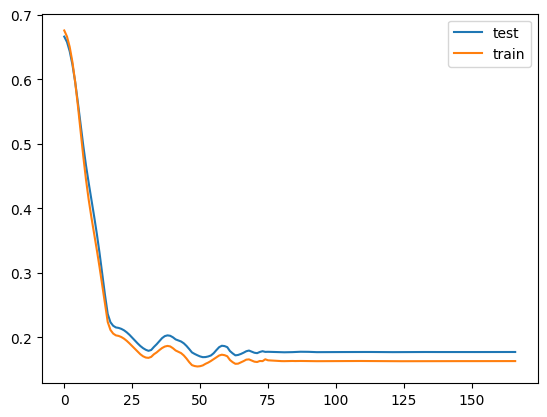

In [55]:
plt.figure()

plt.plot(np.asarray(best_lf_model.validation_error))
plt.plot(np.asarray(best_lf_model.training_error))

plt.legend(['test', 'train'])
plt.show()

# Compare the 3 types of models against one another

In [56]:
import time
from sklearn.model_selection import KFold
import numpy as np

# Assuming models are pre-defined as best_sgd_model, best_scg_model, best_lf_model
models = [best_sgd_model, best_scg_model, best_lf_model]
model_names = ['Stochastic Gradient Descent', 'Scaled Conjugate Gradient', 'Leap Frog Optimiser']

def cross_validate(model, X, y, name, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    scores = []
    folds = []
    times = []
    
    # Store the indices of each fold
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        folds.append(list(val_index))
    
    for n, fold in enumerate(folds):
        start_time = time.time()  # Record start time

        # Test and validation indices for this fold
        X_test, y_test = X[folds[n-1]], y[folds[n-1]]
        X_val, y_val = X[folds[n-2]], y[folds[n-2]]
        
        # Create training set by excluding the test and validation folds
        train_folds = folds.copy()
        train_folds.remove(folds[n-1])
        train_folds.remove(folds[n-2])
        train_indices = np.concatenate(train_folds)
        
        # Prepare training data
        X_train = X[train_indices].reshape(-1, X.shape[1])  # Adjusting the shape accordingly
        y_train = y[train_indices].reshape(-1, 1)
        
        # Update model parameters based on name
        model.random_state = n + 10
        if name == "Scaled Conjugate Gradient":
            model.lambda_bar = 0
            model.lambda_parameter = 1e-6
        
        # Fit the model
        model.fit(X_train, y_train, X_val, y_val)
        
        # Calculate and store the score
        score = model.score(X_test, y_test)
        scores.append(score)
        
        # Calculate the elapsed time and store it
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)
    
    return scores, times

model_cv_scores = []
model_cv_times = []
for name, model in zip(model_names, models):
    scores, times = cross_validate(model, X_pca, y_encoded, name)
    model_cv_scores.append(scores)
    model_cv_times.append(times)

In [57]:
for name, scores in zip(model_names, model_cv_scores):
    print(f"{name}: Mean accuracy = {np.mean(scores):.4f} (+/- {np.std(scores) * 2:.4f})")

Stochastic Gradient Descent: Mean accuracy = 0.9691 (+/- 0.0485)
Scaled Conjugate Gradient: Mean accuracy = 0.9747 (+/- 0.0451)
Leap Frog Optimiser: Mean accuracy = 0.9733 (+/- 0.0408)


In [79]:
for name, times in zip(model_names, model_cv_times):
    print(f"{name}: Mean accuracy = {np.mean(times):.4f} (+/- {np.std(times) * 2:.4f})")

Stochastic Gradient Descent: Mean accuracy = 2.0621 (+/- 2.1504)
Scaled Conjugate Gradient: Mean accuracy = 0.1211 (+/- 0.0748)
Leap Frog Optimiser: Mean accuracy = 1.6545 (+/- 0.8289)


In [58]:
stat, p_value = shapiro(model_cv_scores)

print(f'Statistic={stat}, p-value={p_value}')
if p_value > 0.05:
    print("Data is normally distributed")
else:
    print("Data is not normally distributed")

Statistic=0.8935000290325172, p-value=0.005845623292681742
Data is not normally distributed



Best model (Scaled Conjugate Gradient) test accuracy: 0.9439


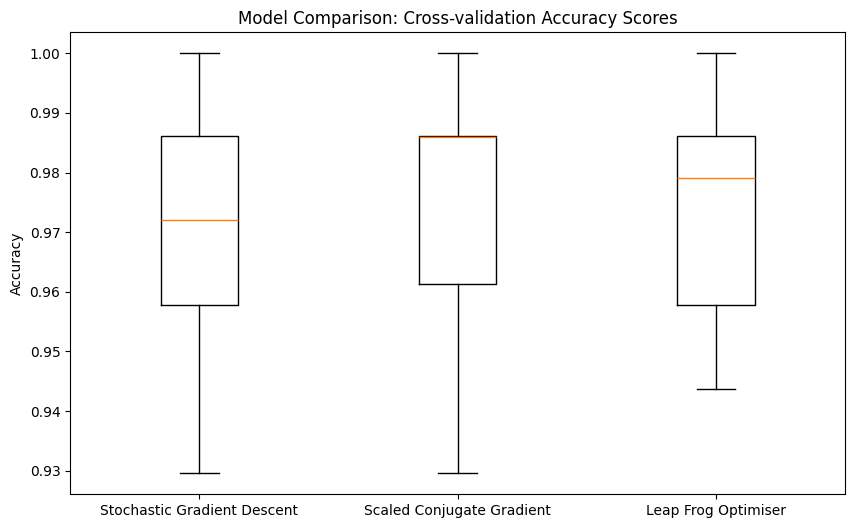

In [59]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.3, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

# Train the best model on the entire training set and evaluate on the test set
best_model_index = np.argmax([np.mean(scores) for scores in model_cv_scores])
best_model = models[best_model_index]
best_model.fit(X_train, y_train, X_val, y_val)
y_pred = best_model.predict(X_test)
y_pred = [0 if u < 0.5 else 1 for u in y_pred]
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest model ({model_names[best_model_index]}) test accuracy: {test_accuracy:.4f}")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.boxplot(model_cv_scores, labels=model_names)
plt.title('Model Comparison: Cross-validation Accuracy Scores')
plt.ylabel('Accuracy')
plt.show()

In [60]:
stat, p_value = kruskal(*model_cv_scores)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 0.3467319517194308, p-value: 0.8408298351063039


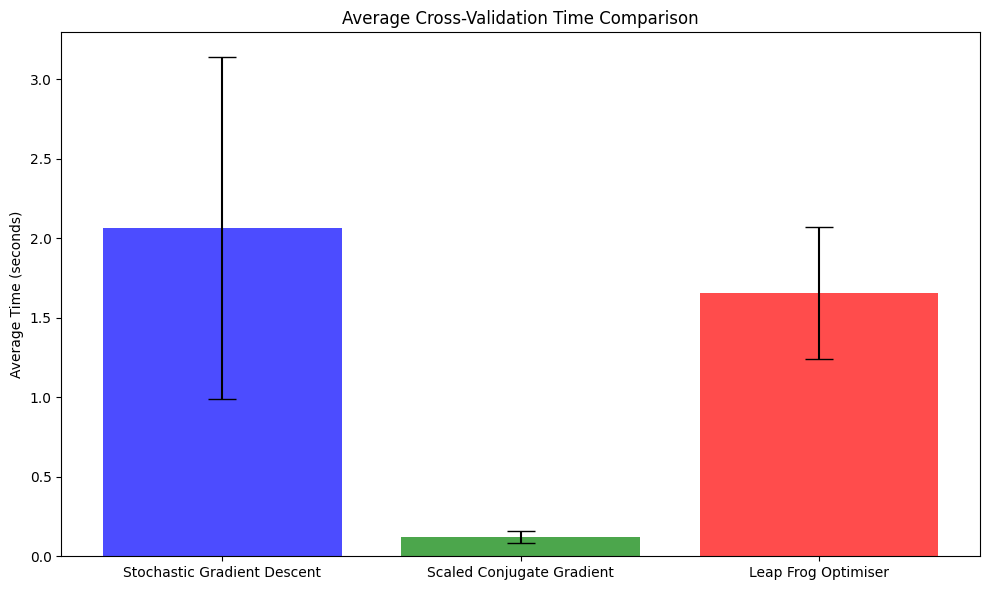

In [61]:
mean_times = [np.mean(times) for times in model_cv_times]
std_times = [np.std(times) for times in model_cv_times]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(model_names))

ax.bar(x_pos, mean_times, yerr=std_times, align='center', alpha=0.7, capsize=10, color=['blue', 'green', 'red'])
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names)
ax.set_ylabel('Average Time (seconds)')
ax.set_title('Average Cross-Validation Time Comparison')
# ax.yaxis.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

In [62]:
stat, p_value = kruskal(*model_cv_times)
print(f"Statistic: {stat}, p-value: {p_value}")

Statistic: 19.365161290322575, p-value: 6.236036596780617e-05


In [63]:
confidence_level = 0.95
def bootstrap_confidence_interval(scores, n_iterations=1000, confidence_level=0.95):
    bootstrapped_means = []
    n_size = len(scores)
    
    # Perform bootstrapping
    for _ in range(n_iterations):
        sample = np.random.choice(scores, size=n_size, replace=True)
        bootstrapped_means.append(np.mean(sample))
    
    # Calculate the confidence interval
    lower_bound = np.percentile(bootstrapped_means, ((1 - confidence_level) / 2) * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 - (1 - confidence_level) / 2) * 100)
    
    return np.mean(scores), lower_bound, upper_bound

# Calculate and print confidence intervals for each model
for name, scores in zip(model_names, model_cv_scores):
    mean_score, lower_ci, upper_ci = bootstrap_confidence_interval(scores)
    print(f"{name} - Mean accuracy: {mean_score:.4f}, {confidence_level*100}% Confidence Interval: [{lower_ci:.4f}, {upper_ci:.4f}]")

Stochastic Gradient Descent - Mean accuracy: 0.9691, 95.0% Confidence Interval: [0.9536, 0.9846]
Scaled Conjugate Gradient - Mean accuracy: 0.9747, 95.0% Confidence Interval: [0.9606, 0.9874]
Leap Frog Optimiser - Mean accuracy: 0.9733, 95.0% Confidence Interval: [0.9606, 0.9860]


In [64]:
def quantile_confidence_interval(scores, lower_quantile=2.5, upper_quantile=97.5, n_iterations=1000):
    bootstrapped_means = []
    n_size = len(scores)
    
    # Perform bootstrapping
    for _ in range(n_iterations):
        sample = np.random.choice(scores, size=n_size, replace=True)
        bootstrapped_means.append(np.mean(sample))
    
    # Calculate the quantile-based confidence interval
    lower_bound = np.percentile(bootstrapped_means, lower_quantile)
    upper_bound = np.percentile(bootstrapped_means, upper_quantile)
    
    return np.mean(scores), lower_bound, upper_bound

# Calculate and print quantile-based confidence intervals for each model
for name, scores in zip(model_names, model_cv_scores):
    mean_score, lower_ci, upper_ci = quantile_confidence_interval(scores)
    print(f"{name} - Mean accuracy: {mean_score:.4f}, 95% Quantile-Based Confidence Interval: [{lower_ci:.4f}, {upper_ci:.4f}]")


Stochastic Gradient Descent - Mean accuracy: 0.9691, 95% Quantile-Based Confidence Interval: [0.9549, 0.9832]
Scaled Conjugate Gradient - Mean accuracy: 0.9747, 95% Quantile-Based Confidence Interval: [0.9606, 0.9874]
Leap Frog Optimiser - Mean accuracy: 0.9733, 95% Quantile-Based Confidence Interval: [0.9606, 0.9860]


In [65]:
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.3, random_state=12, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12, shuffle=True)

In [66]:
y_test_decoded = ['M' if u == 0 else 'B' for u in y_test]

In [67]:
best_sgd_model.fit(X_train, y_train, X_val, y_val)
best_scg_model.fit(X_train, y_train, X_val, y_val)
best_lf_model.fit(X_train, y_train, X_val, y_val)

In [68]:
y_pred_sgd = best_sgd_model.predict(X_test)
y_pred_sgd = ['M' if u < 0.5 else 'B' for u in y_pred_sgd]

y_pred_scg = best_scg_model.predict(X_test)
y_pred_scg = ['M' if u < 0.5 else 'B' for u in y_pred_scg]

y_pred_lf = best_lf_model.predict(X_test)
y_pred_lf = ['M' if u < 0.5 else 'B' for u in y_pred_lf]

In [69]:
print(classification_report(y_test_decoded, y_pred_sgd))

              precision    recall  f1-score   support

           B       0.98      1.00      0.99        49
           M       1.00      0.98      0.99        58

    accuracy                           0.99       107
   macro avg       0.99      0.99      0.99       107
weighted avg       0.99      0.99      0.99       107



In [70]:
print(classification_report(y_test_decoded, y_pred_scg))

              precision    recall  f1-score   support

           B       1.00      0.98      0.99        49
           M       0.98      1.00      0.99        58

    accuracy                           0.99       107
   macro avg       0.99      0.99      0.99       107
weighted avg       0.99      0.99      0.99       107



In [71]:
print(classification_report(y_test_decoded, y_pred_lf))

              precision    recall  f1-score   support

           B       0.98      1.00      0.99        49
           M       1.00      0.98      0.99        58

    accuracy                           0.99       107
   macro avg       0.99      0.99      0.99       107
weighted avg       0.99      0.99      0.99       107



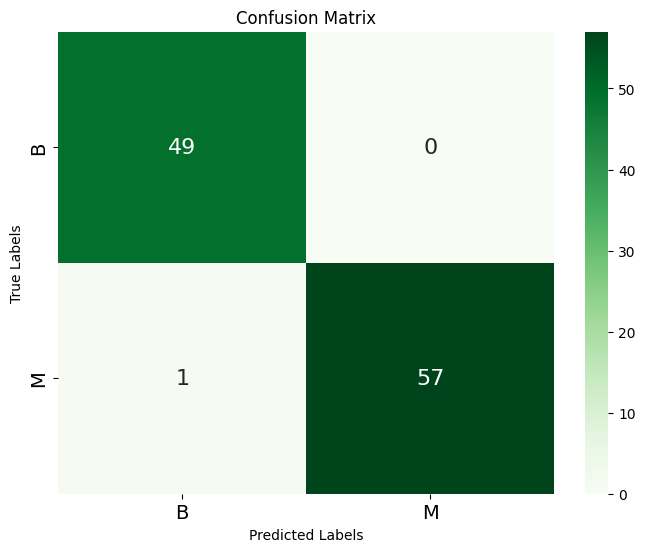

In [85]:
# Create confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_sgd)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y_test_decoded), yticklabels=np.unique(y_test_decoded), annot_kws={"size": 16})

# Adding labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()

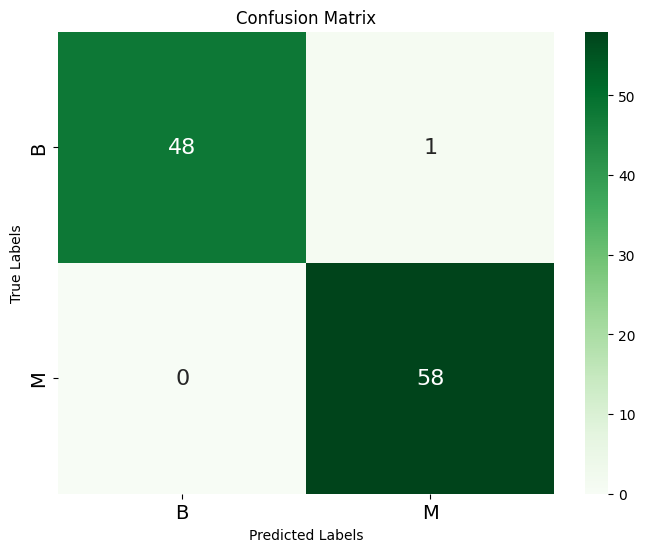

In [87]:
# Create confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_scg)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y_test_decoded), yticklabels=np.unique(y_test_decoded), annot_kws={"size": 16})

# Adding labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()

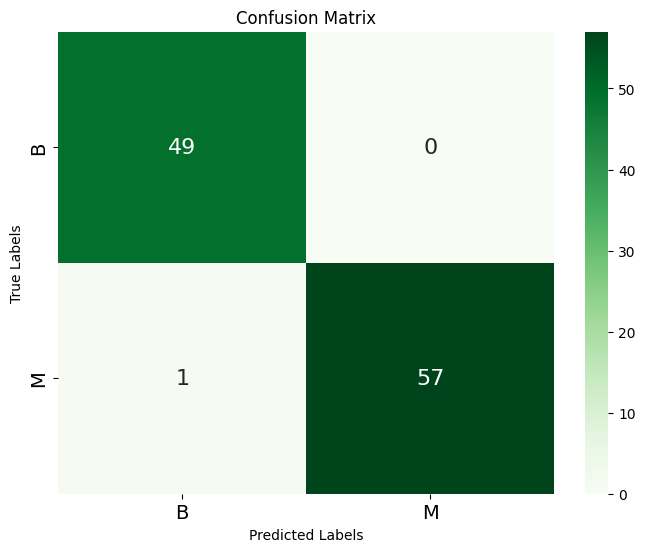

In [84]:
# Create confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_lf)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=np.unique(y_test_decoded), yticklabels=np.unique(y_test_decoded), annot_kws={"size": 16})

# Adding labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()

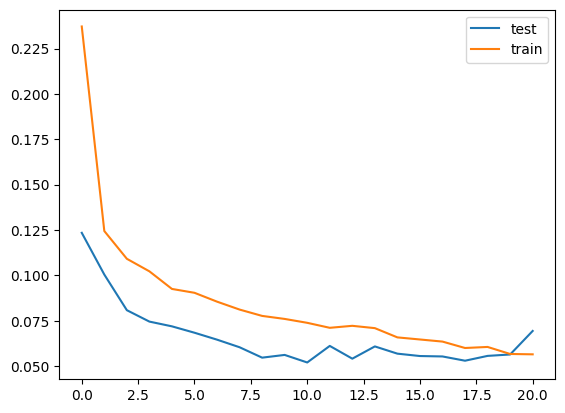

In [75]:
plt.figure()

plt.plot(np.asarray(best_sgd_model.validation_error))
plt.plot(np.asarray(best_sgd_model.training_error))

plt.legend(['test', 'train'])
plt.show()

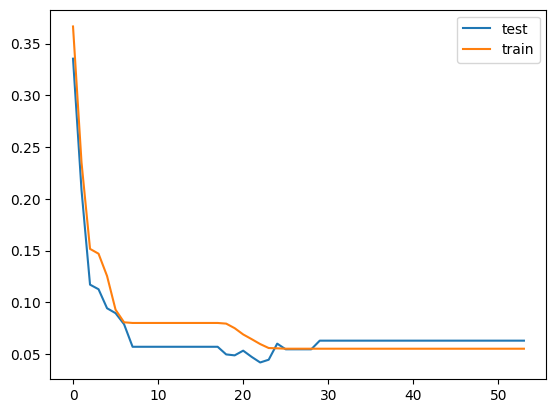

In [76]:
plt.figure()

plt.plot(np.asarray(best_scg_model.validation_error))
plt.plot(np.asarray(best_scg_model.training_error))

plt.legend(['test', 'train'])
plt.show()

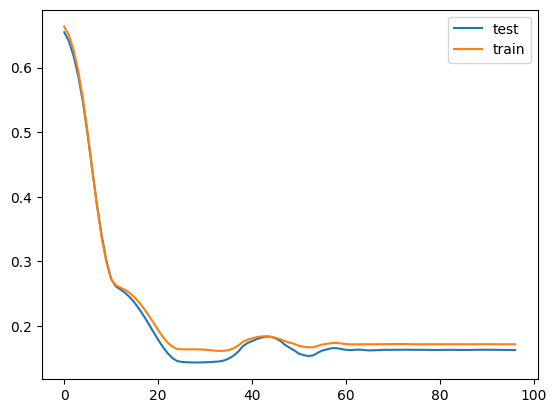

In [77]:
plt.figure()

plt.plot(np.asarray(best_lf_model.validation_error))
plt.plot(np.asarray(best_lf_model.training_error))

plt.legend(['test', 'train'])
plt.show()